In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/Colab_Notebooks/lab/spam_text"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab_Notebooks/lab/spam_text


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Embedding, LSTM, GRU, Bidirectional
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf
import keras.backend as K


In [4]:
#f1 score 학습 지표 함수

def f1(y_true, y_pred):
  y_pred = K.round(y_pred)
  tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
  tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
  fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
  fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

  p = tp / (tp + fp + K.epsilon())
  r = tp / (tp + fn + K.epsilon())

  f1 = 2*p*r / (p+r+K.epsilon())
  "f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)"
  return K.mean(f1)

In [5]:
dt = pd.read_csv('./SPAM_text_message.csv')

In [6]:
dt.sample(5)

,Category,Message
4985,spam,goldviking (29/M) is inviting you to be his fr...
3088,ham,So i asked how's anthony. Dad. And your bf
3894,ham,Have you heard from this week?
3232,ham,No plm i will come da. On the way.
3097,ham,We walked from my moms. Right on stagwood pass...


In [7]:
# 결측치 확인
print('결측값 여부 :',dt.isnull().values.any())

# 데이터 중복 확인
print('Message 중 중복이 아닌 값 :',dt['Message'].nunique())

# 중복 데이터 제거
dt.drop_duplicates(subset=['Message'], inplace=True)

# 제거되었는지 점검
print("중복 제거 후 데이터 크기 :", len(dt))

결측값 여부 : False
Message 중 중복이 아닌 값 : 5157
중복 제거 후 데이터 크기 : 5157


In [8]:
#레이블 비율 봑인
dt.replace('ham', 0, inplace=True)
dt.replace('spam', 1, inplace=True)

print(f'전체 데이터 중 정상 메일의 비율 = {round(dt["Category"].value_counts()[0]/len(dt) * 100,2)}%')
print(f'전체 데이터 중 스팸 메일의 비율 = {round(dt["Category"].value_counts()[1]/len(dt) * 100,2)}%')

groups = dt.groupby(by='Category').count().Message
CNT_HAM = groups[0]
CNT_SPAM = groups[1]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Ham', 'Spam'],
    y=[CNT_HAM, CNT_SPAM],
    marker_color='red',
    width=[0.4,0.4]))

전체 데이터 중 정상 메일의 비율 = 87.57%
전체 데이터 중 스팸 메일의 비율 = 12.43%


=> 두 레이블 간 데이터 비율이 크므로 성능 지표로 f1 score 사용

In [9]:
X_data = dt['Message']
y_data = dt['Category']

# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

word_to_index = tokenizer.word_index

print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'that': 17, 'on': 18, 'call': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'at': 26, 'can': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'ur': 39, 'this': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'go': 46, 'when': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'got': 56, 'then': 57, 'good': 58, 'come': 59, 'am': 60, 'time': 61, 'was': 62, 'its': 63, 'only': 64, 'day': 65, 'love': 66, 'want': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'ü': 72, 'going': 73, 'one': 74, 'need': 75, 'by': 76, 'lor': 77, 'home': 78, 'as': 79, 'about': 80, 'still': 81, 'see': 82, 'txt': 83, 'back': 84, 'r': 85, 'stop': 86, 'da': 87, 'k': 88, 'today': 89, "i'll": 90, 'dont': 91, 'our': 92, 

In [10]:
# 정제 및 정규화
y_list_1 = []
y_list_2 = []

def word_count(threshold):
  total_cnt = len(word_to_index) # 단어의 수
  rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
  total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
  rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

  # 단어와 빈도수의 쌍을 key와 value로 받는다.
  for key, value in tokenizer.word_counts.items():
      total_freq = total_freq + value

      if(value < threshold):
          rare_cnt = rare_cnt + 1
          rare_freq = rare_freq + value

      
  print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
  print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

  y_list_1.append((rare_cnt / total_cnt)*100)
  y_list_2.append((rare_freq / total_freq)*100)

  if(rare_cnt == total_cnt):
    return 0
  else: 
    return 1

In [11]:
# 희귀 단어 빈도수와 비율 확인

stop_point = 0
threshold = 2

while(stop_point):
  stop_point = word_count(threshold)
  if (threshold>10000):
    stop_point = 0
  threshold += 1

<function matplotlib.pyplot.show(*args, **kw)>

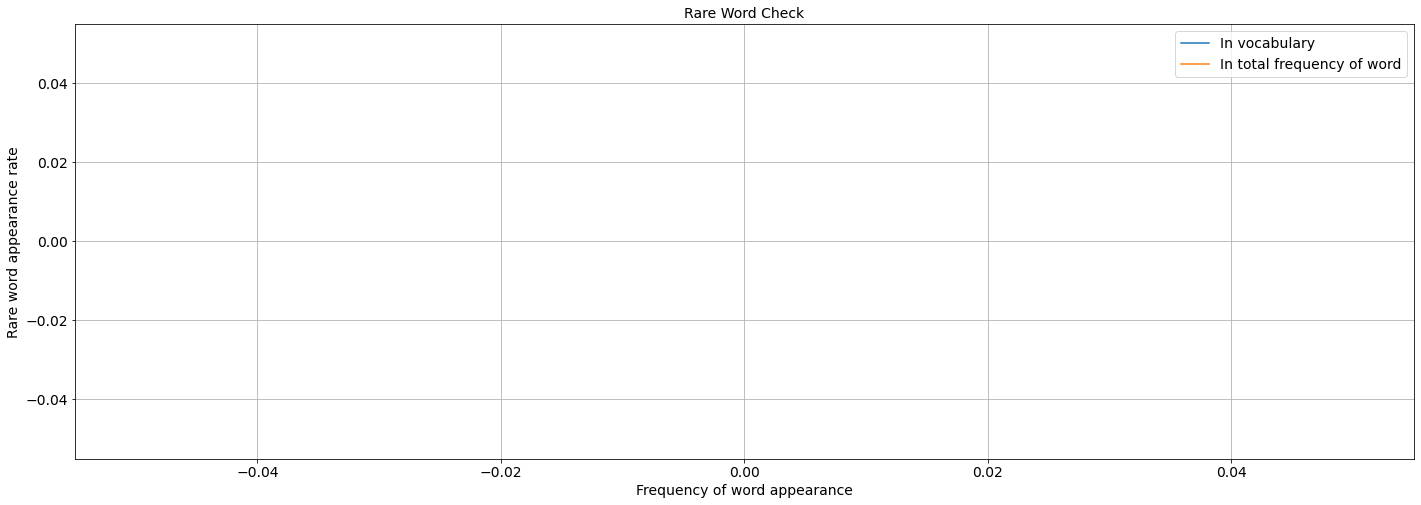

In [12]:
plt.figure(figsize=(24, 8))
plt.title('Rare Word Check', fontsize=14)
plt.xlabel('Frequency of word appearance', fontsize=14)
plt.ylabel('Rare word appearance rate', fontsize=14)
plt.plot(y_list_1, label = 'In vocabulary')
plt.plot(y_list_2, label = 'In total frequency of word')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show

메일의 최대 길이 : 189
메일의 평균 길이 : 15.680628


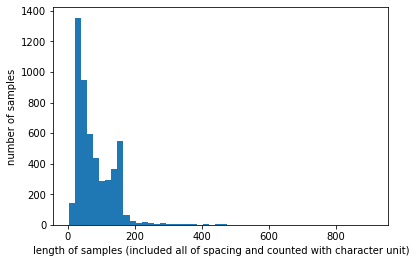

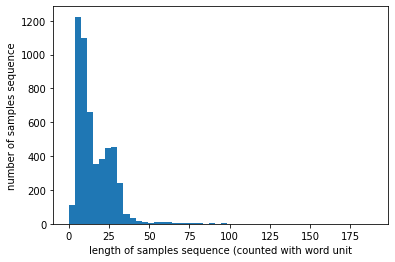

In [13]:
#워드 임베딩 
X_sequences_data = tokenizer.texts_to_sequences(X_data)

#문장 자체의 최대 길이 확인
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_sequences_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_sequences_data))/len(X_sequences_data)))
plt.hist([len(sample) for sample in X_data], bins=50)
# 띄어쓰기와 문자 단위의 길이 계산
plt.xlabel('length of samples (included all of spacing and counted with character unit)')
plt.ylabel('number of samples')
plt.show()

# 단어 단위의 길이 계산
plt.hist([len(sample) for sample in X_sequences_data], bins=50)
plt.xlabel('length of samples sequence (counted with word unit')
plt.ylabel('number of samples sequence')
plt.show()

In [14]:
#최대 길이 기준으로 패딩
MAX_TEXT_LEN = 189
X = pad_sequences(X_sequences_data, maxlen=MAX_TEXT_LEN)  
y = y_data.copy()

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify = y)

In [40]:
# 모델링
vocab_size = 10000

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=MAX_TEXT_LEN))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

callbacks_list = [
    callbacks.EarlyStopping(monitor='f1', min_delta=0.01, patience=15, verbose=1, mode = 'auto'),  
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=15, verbose=1, mode='auto')
]
# ReduceLROnPlateau : 모델의 개선이 없을 경우, learning rate를 조절하는 장치

In [41]:
"""model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')"""
model.compile(metrics=[ f1 ], loss='binary_crossentropy', optimizer='Adam')

In [42]:
history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_split=0.2,  callbacks=callbacks_list)

Epoch 1/15
26/26 [==============================] - 20s 620ms/step - loss: 0.5064 - f1: 0.0246 - val_loss: 0.3239 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/15
26/26 [==============================] - 16s 602ms/step - loss: 0.1972 - f1: 0.4632 - val_loss: 0.1289 - val_f1: 0.8066 - lr: 0.0010
Epoch 3/15
26/26 [==============================] - 16s 601ms/step - loss: 0.0781 - f1: 0.9236 - val_loss: 0.0616 - val_f1: 0.9207 - lr: 0.0010
Epoch 4/15
26/26 [==============================] - 15s 590ms/step - loss: 0.0239 - f1: 0.9816 - val_loss: 0.0468 - val_f1: 0.9435 - lr: 0.0010
Epoch 5/15
26/26 [==============================] - 15s 589ms/step - loss: 0.0100 - f1: 0.9873 - val_loss: 0.0465 - val_f1: 0.9338 - lr: 0.0010
Epoch 6/15
26/26 [==============================] - 16s 601ms/step - loss: 0.0054 - f1: 0.9953 - val_loss: 0.0624 - val_f1: 0.9422 - lr: 0.0010
Epoch 7/15
26/26 [==============================] - 16s 629ms/step - loss: 0.0041 - f1: 0.9971 - val_loss: 0.0679 - val_f1: 0.9351 -

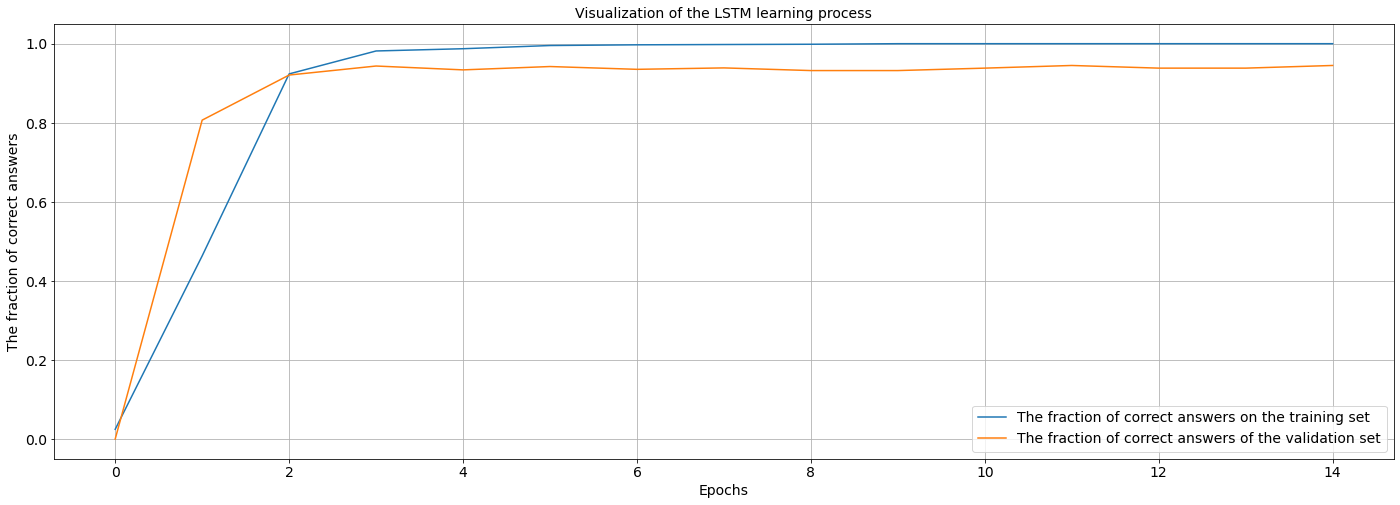

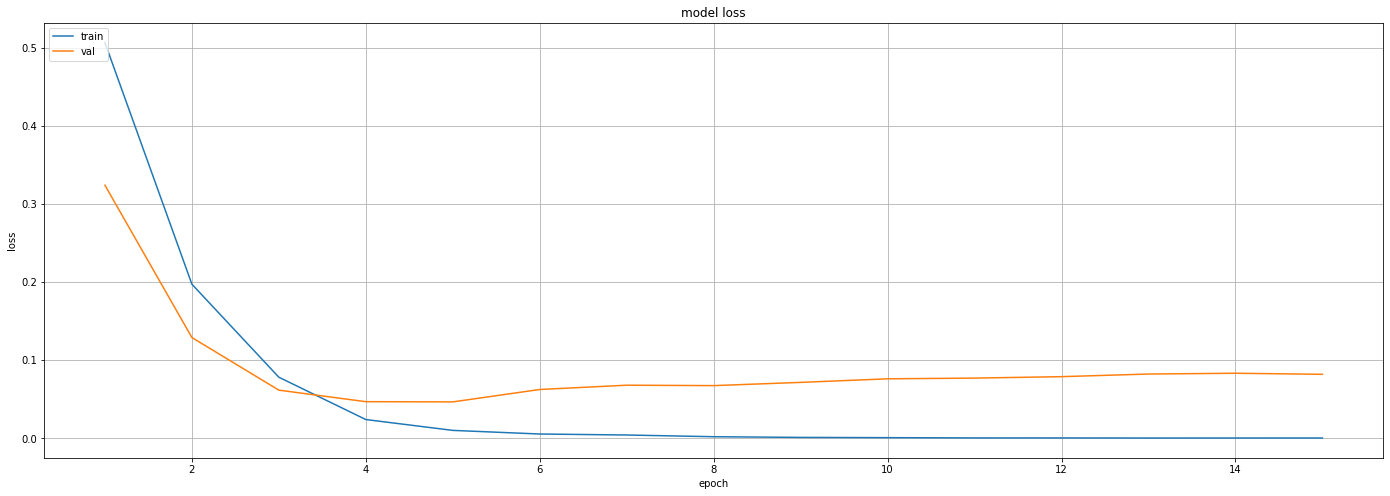

In [46]:
# 학습과정 시각화

plt.figure(figsize=(24, 8))
plt.title('Visualization of the LSTM learning process', fontsize=14)
plt.plot(history.history['f1'], label='The fraction of correct answers on the training set') 
plt.plot(history.history['val_f1'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()


# 오차함수 시각화

epochs = range(1, len(history.history['f1']) + 1)
plt.figure(figsize=(24, 8))
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [47]:
# 확률 값 -> 이진 값으로 변환

pred = model.predict(X_test)
threshold_score = 0.6

for i in range(len(pred)):
  if pred[i] >= threshold_score:
    pred[i] = 1
  else:
    pred[i] = 0

print(f1_score(y_test, pred))

33/33 [==============================] - 2s 58ms/step
0.9311740890688258


In [48]:
# 결과 확인
print(f'테스트 데이터 정확도 : {model.evaluate(X_test, y_test)[1]}')

33/33 [==============================] - 1s 39ms/step - loss: 0.0924 - f1: 0.9203
테스트 데이터 정확도 : 0.9202520251274109


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 189, 128)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 32)                20608     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,302,785
Trainable params: 1,302,785
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 스팸 메일 판별 함수 
def ml_pipeline(text: str) -> str:
    """LSTM model prediction function for this sample"""
    try:
        sequence = tokenizer.texts_to_sequences([text])
        sequence = pad_sequences(sequence, maxlen=MAX_TEXT_LEN)
        if sequence.max() == 0:
            return 'Enter the words in English'
        else:
            predict = model.predict(sequence, verbose=0)
            if predict > 0.5:
                return 'The text is spam'
            else:
                return 'The text is not spam'
    except AttributeError:
        return 'Enter the text'

In [23]:
 ml_pipeline('if you subscribe, you can use freely this service. only today you should buy this model 40$')


'The text is not spam'

In [24]:
ml_pipeline('SPAT Devices is a bundle of advanced tools by Music Unit that let you dial in detailed interactions between your sounds and the space around them. Turn a simple stereo mix into a binaural soundscape with precisely modeled panning algorithms and psychoacoustic parameters – or use the Multichannel Pack to program multiple speakers for immersive playback. Check out the devices ›')

'The text is not spam'